<a href="https://colab.research.google.com/github/szstein22/BD4H_project/blob/main/BD4H_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from google.colab import drive
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
#mount data
# # View current working directory
# print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/gdrive')

# Change working directory to your file position
path = "/content/gdrive/My Drive/BD4H_project/data"
os.chdir(path)

#csv location
#folder_path = 'HIDS-501-master/data/mimic-iii-demo/'


# load files function
def load_csv(filename):
    return pd.read_csv(os.path.join(filename))
#loading files
admissions = load_csv('ADMISSIONS.csv')
patients = load_csv('PATIENTS.csv')
diagnoses = load_csv('DIAGNOSES_ICD.csv')
icd_diagnoses = load_csv('D_ICD_DIAGNOSES.csv')
note_events = load_csv('NOTEEVENTS.csv')
labevents = load_csv('LABEVENTS.csv')
prescriptions = load_csv('PRESCRIPTIONS.csv')


Mounted at /content/gdrive


In [ ]:
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [ ]:
# Merge patients and admissions on subject_id
patient_data = pd.merge(patients, admissions, on='subject_id', how='inner')

# Select relevant columns
#patient_data = patient_data[['subject_id', 'gender', 'dob', 'admittime', 'dischtime', 'deathtime', 'ethnicity']]

# Convert date columns to datetime format
patient_data['dob'] = pd.to_datetime(patient_data['dob'])
patient_data['admittime'] = pd.to_datetime(patient_data['admittime'])
patient_data['dischtime'] = pd.to_datetime(patient_data['dischtime'])
patient_data['deathtime'] = pd.to_datetime(patient_data['deathtime'])

# Calculate age at admission (approximate)
#patient_data['age'] = (patient_data['admittime'] - patient_data['dob']).dt.days / 365.25


In [ ]:
patient_data.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,9467,10006,F,2094-03-05,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,...,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,9472,10011,F,2090-06-05,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,...,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,9474,10013,F,2038-09-03,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,12265,165520,...,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,9478,10017,F,2075-09-21,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,12269,199207,...,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,9479,10019,M,2114-06-20,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,12270,177759,...,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [ ]:
patient_data.diagnosis.unique()

array(['SEPSIS', 'HEPATITIS B', 'HUMERAL FRACTURE', 'ALCOHOLIC HEPATITIS',
       'STROKE/TIA',
       ' MITRAL REGURGITATION;CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR  ? MITRAL VALVE REPLACEMENT /SDA',
       'SYNCOPE;TELEMETRY', 'RIGHT HUMEROUS FRACTURE',
       'RENAL FAILIURE-SYNCOPE-HYPERKALEMIA',
       'RECURRENT LEFT CAROTID STENOSIS,PRE HYDRATION',
       'FAILURE TO THRIVE', 'PULMONARY EDEMA\\CATH', 'UNSTABLE ANGINA',
       'RESPIRATORY DISTRESS', 'METASTATIC MELANOMA;BRAIN METASTASIS',
       'FEVER', 'BRAIN METASTASES', 'VARICEAL BLEED', 'LOWER GI BLEED',
       'CHEST PAIN/ CATH', 'SUBDURAL HEMATOMA/S/P FALL',
       'ESOPHAGEAL CANCER/SDA', 'S/P MOTORCYCLE ACCIDENT', 'SEIZURE',
       'GASTROINTESTINAL BLEED', 'LUNG CANCER;SHORTNESS OF BREATH',
       'HYPOTENSION', 'SEPSIS;PNEUMONIA;TELEMETRY',
       'CONGESTIVE HEART FAILURE', 'UROSEPSIS', 'BASAL GANGLIN BLEED',
       'OVERDOSE', 'CRITICAL AORTIC STENOSIS/HYPOTENSION',
       'HYPOTENSION;TELEMET

In [ ]:
patient_data.diagnosis = patient_data.diagnosis.str.replace(";"," ").str.strip()
all_diagnosis_str = patient_data.diagnosis.str.cat(sep=" ")

subs = {"\\":" ", "-":"", "/":"", "?":""}
for s in subs.keys():
    all_diagnosis_str = all_diagnosis_str.replace(s, subs[s])

all_diagnosis = all_diagnosis_str.split(" ")

import collections
c = collections.Counter(all_diagnosis)
c.most_common(5)
top_6_keyword = sorted(c, key=c.get, reverse=True)[:6]
print(f"Top 5 most common diagnostic terms are: {top_6_keyword}")


Top 5 most common diagnostic terms are: ['SEPSIS', 'FAILURE', 'PNEUMONIA', 'TELEMETRY', 'BLEED', 'ACUTE']


In [ ]:
for keyword in top_6_keyword:
    patient_data[keyword]=patient_data['diagnosis'].str.contains(keyword)

In [ ]:
patient_data.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,SEPSIS,FAILURE,PNEUMONIA,TELEMETRY,BLEED,ACUTE
0,9467,10006,F,2094-03-05,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,...,2164-10-23 23:00:00,SEPSIS,0,1,True,False,False,False,False,False
1,9472,10011,F,2090-06-05,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,...,NaN,HEPATITIS B,1,1,False,False,False,False,False,False
2,9474,10013,F,2038-09-03,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,12265,165520,...,NaN,SEPSIS,1,1,True,False,False,False,False,False
3,9478,10017,F,2075-09-21,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,12269,199207,...,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,False,False,False,False,False,False
4,9479,10019,M,2114-06-20,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,12270,177759,...,NaN,ALCOHOLIC HEPATITIS,1,1,False,False,False,False,False,False


In [ ]:
diagnoses.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


In [ ]:
diagnoses['icd9_code'].unique()[:10]

array(['99591', '99662', '5672', '40391', '42731', '4280', '4241', '4240',
       '2874', '03819'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each ICD-9 code
icd_code_counts = diagnoses['icd9_code'].value_counts().reset_index()
icd_code_counts.columns = ['icd9_code', 'count']
icd_code_counts.columns = ['ICD9_Code', 'Count']

# Sort the DataFrame by the count in descending order
icd_code_counts = icd_code_counts.sort_values(by='Count', ascending=False)
icd_code_counts

,ICD9_Code,Count
0,4019,53
1,42731,48
2,5849,45
3,4280,39
4,25000,31
...,...,...
364,34570,1
363,3315,1
362,V4983,1
361,4139,1


<ipython-input-14-0850157c018e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=icd_code_counts_top, x='Count', y='ICD9_Code', palette="viridis")


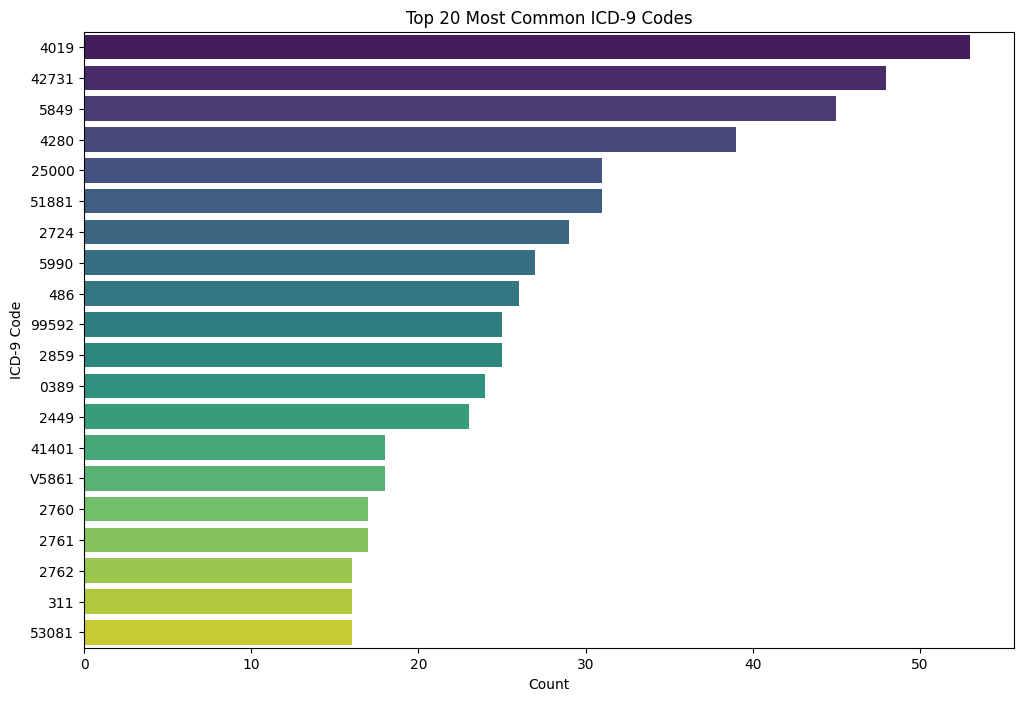

In [ ]:
top_n = 20
icd_code_counts_top = icd_code_counts.head(top_n)

# Plot the counts of each ICD-9 code
plt.figure(figsize=(12, 8))
sns.barplot(data=icd_code_counts_top, x='Count', y='ICD9_Code', palette="viridis")
plt.title(f"Top {top_n} Most Common ICD-9 Codes")
plt.xlabel("Count")
plt.ylabel("ICD-9 Code")
plt.show()

In [ ]:
## Preprocessing Continued

# Fill missing numerical columns with the mean
numerical_columns = patient_data.select_dtypes(include=[np.number]).columns
patient_data[numerical_columns] = patient_data[numerical_columns].fillna(patient_data[numerical_columns].mean())

# Fill categorical columns with a placeholder value 'Unknown'
categorical_columns = patient_data.select_dtypes(exclude=[np.number]).columns
patient_data[categorical_columns] = patient_data[categorical_columns].fillna('Unknown')


In [ ]:
## Feature Engineering

# Age at admission
patient_data['age_at_admission'] = (
    (patient_data['admittime'].dt.year - patient_data['dob'].dt.year) -
    ((patient_data['admittime'].dt.month < patient_data['dob'].dt.month) |
     ((patient_data['admittime'].dt.month == patient_data['dob'].dt.month) & (patient_data['admittime'].dt.day < patient_data['dob'].dt.day))
    ).astype(int)
)

# Length of stay
patient_data['length_of_stay'] = (patient_data['dischtime'] - patient_data['admittime']).dt.days

# One-hot encode categorical variables and add to dataset
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_columns_to_encode = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']

for column in categorical_columns_to_encode:
    encoded = encoder.fit_transform(patient_data[[column]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.categories_[0])
    patient_data = pd.concat([patient_data, encoded_df], axis=1)

# Step 5: Vectorize diagnosis terms using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # Limit to 100 features for simplicity
diagnosis_matrix = vectorizer.fit_transform(patient_data['diagnosis'])

# Convert the sparse matrix to a dense DataFrame and concatenate with patient data
diagnosis_df = pd.DataFrame(diagnosis_matrix.toarray(), columns=vectorizer.get_feature_names_out())
patient_data = pd.concat([patient_data, diagnosis_df], axis=1)

# Step 6: Aggregating data (e.g., number of diagnoses per patient)
patient_data['num_diagnoses'] = patient_data['diagnosis'].apply(lambda x: len(x.split(" ")))

# Step 7: Inspecting the final dataframe
print(patient_data.head())

   row_id_x  subject_id gender        dob                  dod  \
0      9467       10006      F 2094-03-05  2165-08-12 00:00:00   
1      9472       10011      F 2090-06-05  2126-08-28 00:00:00   
2      9474       10013      F 2038-09-03  2125-10-07 00:00:00   
3      9478       10017      F 2075-09-21  2152-09-12 00:00:00   
4      9479       10019      M 2114-06-20  2163-05-15 00:00:00   

              dod_hosp              dod_ssn  expire_flag  row_id_y  hadm_id  \
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1     12258   142345   
1  2126-08-28 00:00:00              Unknown            1     12263   105331   
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1     12265   165520   
3              Unknown  2152-09-12 00:00:00            1     12269   199207   
4  2163-05-15 00:00:00  2163-05-15 00:00:00            1     12270   177759   

   ... upper urinary urosepsis  uti valve variceal vehicle   vf with  \
0  ...   0.0     0.0       0.0  0.0   0.0      0.0     0

****Patient Similarity Scores****

In [ ]:
record_counts = patient_data['subject_id'].value_counts().sort_values(ascending=False)
record_counts

patient_data[patient_data['subject_id'] == 41976]

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,upper,urinary,urosepsis,uti,valve,variceal,vehicle,vf,with,num_diagnoses
76,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40396,125449,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
77,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40397,173269,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
78,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40398,176016,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
79,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40399,172082,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
80,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40400,152032,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
81,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40401,130681,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
82,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40402,180546,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
83,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40403,174863,...,0.0,0.491918,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4
84,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40404,125013,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
85,31311,41976,M,2136-07-28,2202-12-05 00:00:00,Unknown,2202-12-05 00:00:00,1,40405,155297,...,0.0,0.000000,0.0,0.828087,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
patients_data_sim = pd.merge(patient_data, admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))

#patients_data_sim.head()
available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
categorical_features = [feature for feature in available_categorical_features if feature in patients_data_sim.columns]
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])
X = patients_data_sim[features]
y = patients_data_sim['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
#similarity_matrix = cosine_similarity(X_train_processed)

## Print similarity matrix (consider limiting the size for large datasets)
#print("Similarity Matrix (truncated):")
#print(similarity_matrix[:5, :5])  # Print the first 5 rows and columns

# Calculate and print cosine similarity for specific patients
#patient_index_1 = 0  # Index of the first patient
#patient_index_2 = 1  # Index of the second patient
#cosine_sim = cosine_similarity(X_train_processed[patient_index_1].reshape(1, -1),
#                               X_train_processed[patient_index_2].reshape(1, -1))[0][0]
#print(f"Cosine similarity between patient {patient_index_1} and {patient_index_2}: {cosine_sim}")

# Plot heatmap of similarity matrix (consider limiting size for large datasets)
#plt.figure(figsize=(15, 12))
#sns.heatmap(similarity_matrix[:20, :20], annot=True, cmap="viridis", fmt=".2f")  # Limit to 20x20 for visualization
#plt.title("Similarity Matrix Heatmap")
#plt.show()


Similarity Matrix (truncated):
[[1.         0.50403141 0.64286097 0.74896485 0.50074172]
 [0.50403141 1.         0.66188466 0.49877667 0.57395392]
 [0.64286097 0.66188466 1.         0.61630384 0.74727344]
 [0.74896485 0.49877667 0.61630384 1.         0.61156436]
 [0.50074172 0.57395392 0.74727344 0.61156436 1.        ]]


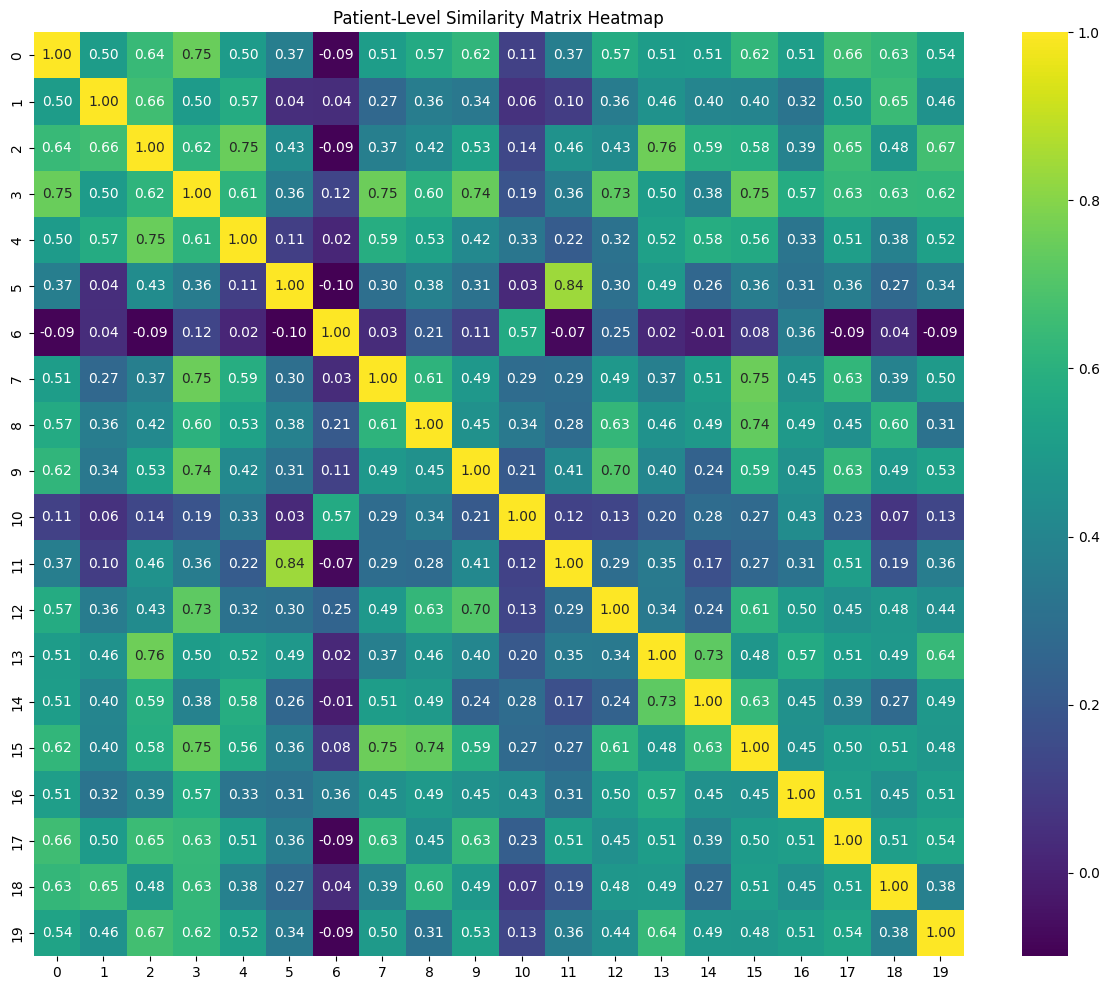

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate data per patient by grouping by 'subject_id'
patient_data_agg = patients_data_sim.groupby('subject_id').agg({
    'age_at_admission': 'mean',  # Average age across admissions
    'length_of_stay': 'mean',    # Average length of stay across admissions
    'num_diagnoses': 'max',      # Use max diagnoses count (or any relevant choice)
    **{col: lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] for col in categorical_features}
    #**{col: 'first' for col in categorical_features}  # Take the first value of each categorical feature (or mode)
}).reset_index()

# Define features for patient-level similarity
X = patient_data_agg[features]
y = patient_data_agg['hospital_expire_flag'] if 'hospital_expire_flag' in patient_data_agg.columns else None

# Step 2: Apply transformations to numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform preprocessor
X_processed = preprocessor.fit_transform(X)

# Step 3: Compute similarity matrix
similarity_matrix = cosine_similarity(X_processed)

# Step 4: Visualize similarity matrix (truncated for readability)
print("Similarity Matrix (truncated):")
print(similarity_matrix[:5, :5])

# Optional: Plot heatmap for the first few patients' similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_matrix[:20, :20], annot=True, cmap="viridis", fmt=".2f")  # Limited to 20x20 for visualization
plt.title("Patient-Level Similarity Matrix Heatmap")
plt.show()


*** Modeling for Diagnostic prediction for Clinical Decision Support***

In [ ]:
## Build a model for 4019 only

# Step 1: Filter for ICD-9 Code 4019 (Hypertension, unspecified)
patients_with_4019 = diagnoses[diagnoses['icd9_code'] == '4019']

# Merge with preprocessed patient data to get relevant patient information
# -- changed: Merge on subject_id to keep 'hadm_id' from patients_with_4019
patients_4019_data = pd.merge(patients_with_4019, patient_data, on='subject_id', how='inner', suffixes=('','_patient_data'))
patients_4019_data.head()

# Extract discharge diagnosis from ADMISSIONS (discharge diagnosis can be found in the 'diagnosis' field in ADMISSIONS)
# patients_4019_data should now have 'hadm_id' for the merge
patients_4019_data = pd.merge(patients_4019_data, admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))
patients_4019_data.head()

# Step 2: Encode the discharge diagnosis
# We will use LabelEncoder to convert the discharge diagnosis into numeric labels
label_encoder = LabelEncoder()
patients_4019_data['diagnosis_encoded'] = label_encoder.fit_transform(patients_4019_data['diagnosis'])

# Step 3: Prepare the features for the model (we’ll exclude the 'diagnosis' and 'diagnosis_encoded' columns)
# features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + \
#            list(patients_4019_data.columns[patients_4019_data.columns.str.startswith('admission_type')])

# # Separate categorical and numerical features
# categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
# numerical_features = [feature for feature in features if feature not in categorical_features]

# Check available categorical columns in the dataframe
available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']

# Only keep columns that exist in the dataframe
categorical_features = [feature for feature in available_categorical_features if feature in patients_4019_data.columns]

#Added by Umair
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']

# Prepare features for model (updated to include only existing columns)
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Step 5: Create a pipeline to preprocess the data and train the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 6: Split the data into training and testing sets (80% training, 20% testing)
X = patients_4019_data[features]
y = patients_4019_data['diagnosis_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the Random Forest classifier using the pipeline
model_pipeline.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print(classification_report(y_test, y_pred))

# Optional: Save the preprocessed data and model for later use
# patients_4019_data.to_csv('preprocessed_patient_data_4019.csv', index=False)
# joblib.dump(model_pipeline, 'random_forest_model_4019.pkl')

Model accuracy: 84.31%
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       1.00      0.75      0.86         4
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          20       1.00      1.00      1.00         5
          29       0.80      1.00      0.89        12
          32       1.00      1.00      1.00         1
          34       1.00      0.93      0.96        14
          36       1.00      1.00      1.00         1
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

****Single diagnosis Classification****

In [ ]:
#patients_4019_data['diagnosis_encoded'].nunique()
#diagnoses[diagnoses['icd9_code'] == '4019']
diagnoses
patients_with_4019 = diagnoses[diagnoses['icd9_code'] == '4019']
patients_diagnoses_data = pd.merge(patient_data,patients_with_4019, on='subject_id', how='left', suffixes=('','_patient_data'))
#patients_diagnoses_admission_data = pd.merge(patients_diagnoses_data, admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))

In [ ]:
#patients_diagnoses_data.head()
patients_diagnoses_data['icd9_code_label'] = patients_diagnoses_data['icd9_code'].fillna(0).replace('4019', 1)
patients_diagnoses_data['icd9_code_label'].unique()

<ipython-input-49-8936575c1f0a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patients_diagnoses_data['icd9_code_label'] = patients_diagnoses_data['icd9_code'].fillna(0).replace('4019', 1)


array([0, 1])

In [ ]:
patients_diagnoses_admission_data = pd.merge(patients_diagnoses_data, admissions[['row_id', 'subject_id','hadm_id','admittime','admission_type','admission_location','insurance','hospital_expire_flag','hospital_expire_flag']], on='hadm_id', how='left', suffixes=('','_admissions'))

In [ ]:
admissions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

In [ ]:
modeling_df = patients_diagnoses_admission_data[['SEPSIS', 'FAILURE', 'PNEUMONIA', 'TELEMETRY', 'BLEED', 'ACUTE','admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission',
                                                 'length_of_stay','num_diagnoses','hospital_expire_flag','SINGLE','Medicaid','Medicare','icd9_code_label']]

In [ ]:
available_categorical_features = ['SEPSIS', 'FAILURE', 'PNEUMONIA', 'TELEMETRY', 'BLEED', 'ACUTE','admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
categorical_features = [feature for feature in available_categorical_features if feature in modeling_df.columns]
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']


# Prepare features for model (updated to include only existing columns)
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Step 5: Create a pipeline to preprocess the data and train the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 6: Split the data into training and testing sets (80% training, 20% testing)
X = modeling_df[features]
y = modeling_df['icd9_code_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the Random Forest classifier using the pipeline
model_pipeline.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print(classification_report(y_test, y_pred))


Model accuracy: 87.69%
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.94      0.90      0.92        50

    accuracy                           0.88        65
   macro avg       0.82      0.85      0.83        65
weighted avg       0.88      0.88      0.88        65

